<a href="https://colab.research.google.com/github/dinhsang1999/Deep-Learning-with-PyTorch-ImageSegmentation/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [177]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-8xf1eyls
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-8xf1eyls


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [178]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


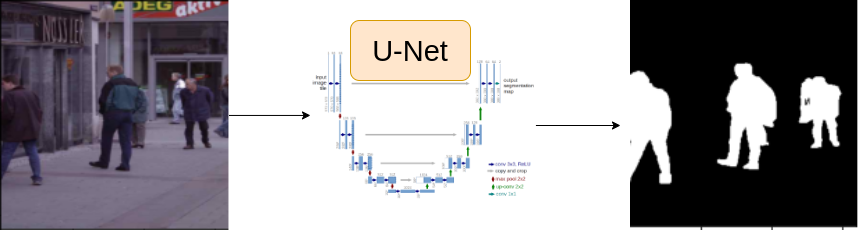

# Some Common Imports

In [179]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [180]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [181]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda:0'

EPOCH = 20
LR = 0.003
IMAGE_SIZE = 256
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHT = 'imagenet'

In [182]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [183]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

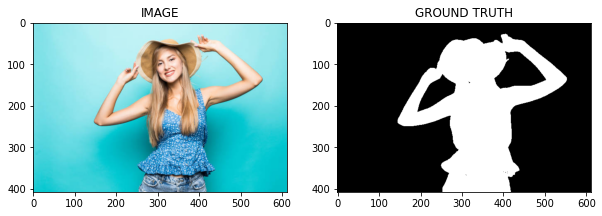

In [184]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [185]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state = 34)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [186]:
import albumentations as A

In [187]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)
  ])
def get_valid_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [188]:
from torch.utils.data import Dataset

In [189]:
class SegmentationDataset(Dataset):

  def __init__(self, df , augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #h,w,c
    mask = np.expand_dims(mask,axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image , mask = mask)
      image = data['image']
      mask = data['mask']
    
    #hwc --> c,h,w

    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.Tensor(mask) / 255.0

    return image,mask

In [190]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_train_augs())

In [191]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


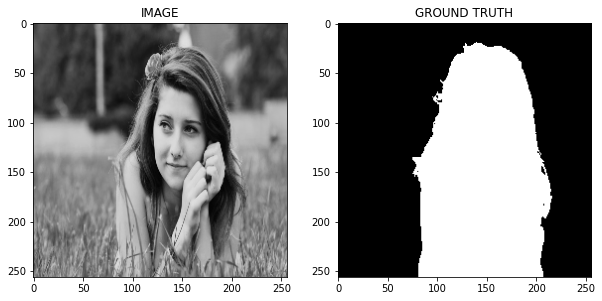

In [192]:
idx = 10

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [193]:
from torch.utils.data import DataLoader   

In [194]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE)

In [195]:
print(f'total no. of batches of trainloader : {len(trainloader)}')
print(f'total no. of batches of validloader : {len(validloader)}')


total no. of batches of trainloader : 15
total no. of batches of validloader : 4


In [196]:
for image, mask in trainloader:
  break

print(f'One batch image shape: {image.shape}')
print(f"One batch mask images: {mask.shape}")


One batch image shape: torch.Size([16, 3, 256, 256])
One batch mask images: torch.Size([16, 1, 256, 256])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [197]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [198]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
      encoder_name = ENCODER,
      encoder_weights = WEIGHT,
      in_channels = 3,
      classes = 1,
      activation = None
    )
  def forward(self, images,masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1+loss2
    
    return logits


In [199]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [200]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in data_loader:

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss  = model(images,masks)
    loss.to(DEVICE)
    logits.to(DEVICE)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  return total_loss / len(data_loader)

In [201]:

def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss  = model(images,masks)

      total_loss += loss.item()
    
    return total_loss / len(data_loader)

# Task 8 : Train Model

In [202]:
optimizer  = torch.optim.Adam(model.parameters(),lr = LR)

In [203]:
best_valid_loss = np.Inf
for i in range(EPOCH):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader,model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss
  
  print(f'Epoch: {i+1} Train_loss {train_loss} Valid_loss: {valid_loss}')



100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


SAVED MODEL
Epoch: 1 Train_loss 0.7773856401443482 Valid_loss: 1.2497016787528992


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


SAVED MODEL
Epoch: 2 Train_loss 0.3916057606538137 Valid_loss: 0.585335798561573


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


SAVED MODEL
Epoch: 3 Train_loss 0.3307331293821335 Valid_loss: 0.30408839881420135


100%|██████████| 4/4 [00:00<00:00,  6.05it/s]


SAVED MODEL
Epoch: 4 Train_loss 0.3190199136734009 Valid_loss: 0.2907840125262737


100%|██████████| 4/4 [00:00<00:00,  6.07it/s]


SAVED MODEL
Epoch: 5 Train_loss 0.2758719682693481 Valid_loss: 0.23806576058268547


100%|██████████| 4/4 [00:00<00:00,  6.11it/s]


Epoch: 6 Train_loss 0.23644165794054667 Valid_loss: 0.2550954967737198


100%|██████████| 4/4 [00:00<00:00,  6.12it/s]


Epoch: 7 Train_loss 0.23562537729740143 Valid_loss: 0.2747303359210491


100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


SAVED MODEL
Epoch: 8 Train_loss 0.20328987936178844 Valid_loss: 0.21257950738072395


100%|██████████| 4/4 [00:00<00:00,  6.14it/s]


Epoch: 9 Train_loss 0.18543601632118226 Valid_loss: 0.25602275133132935


100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


Epoch: 10 Train_loss 0.14534567495187123 Valid_loss: 0.21921078488230705


100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


Epoch: 11 Train_loss 0.13580615719159445 Valid_loss: 0.23817967996001244


100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


Epoch: 12 Train_loss 0.1677776133020719 Valid_loss: 0.23843051493167877


100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


Epoch: 13 Train_loss 0.16001923779646557 Valid_loss: 0.2825169637799263


100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


Epoch: 14 Train_loss 0.21638838748137157 Valid_loss: 0.22940047830343246


100%|██████████| 4/4 [00:00<00:00,  6.10it/s]


Epoch: 15 Train_loss 0.17848009566466014 Valid_loss: 0.2627080902457237


100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


Epoch: 16 Train_loss 0.1557002916932106 Valid_loss: 0.24897199496626854


100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


SAVED MODEL
Epoch: 17 Train_loss 0.17937950789928436 Valid_loss: 0.20180080085992813


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Epoch: 18 Train_loss 0.14447455753882726 Valid_loss: 0.25738707184791565


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


Epoch: 19 Train_loss 0.13284275780121485 Valid_loss: 0.21009444072842598


100%|██████████| 4/4 [00:00<00:00,  4.18it/s]

Epoch: 20 Train_loss 0.11311203539371491 Valid_loss: 0.20557459071278572


# Task 9 : Inference

In [206]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image,mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

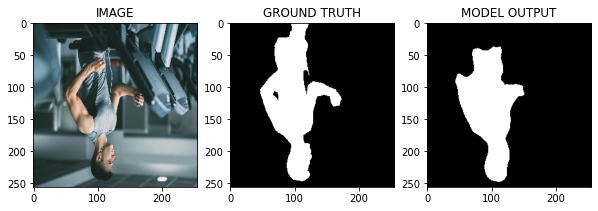

In [207]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya